# Analyse des données hospitalières relatives à l'épidémie de COVID-19

Sur ce notebook, nous allons traiter et visualiser les données hospitalières relatives liée à l'épidemie de COVID-19 en France.

Pour cela, nous avons utilisé le Dataset du gouvernement français : https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/ , un jeu de donnée de Santé public France qui est un service certifié. 

Il faut savoir que certains fichiers peuvent comporter des anomalies du fait des difficultés de collecte des données selon le site de data.gouv ainsi que pour certains patients la tranche d'âge et/ou le sexe n'est pas identifié.

Le jeu de données renseigne sur la situation hospitalières concernant l'épidémie de COVID-19 en France et est composé de ces fichiers :

- cases_.csv correspondant aux données hospitalières par département et sexe du patient avec le nombre de patients hospitalisés, le nombre de personnes actuellement en réanimation ou soins intensifs, le nombre cumulé de personnes retournées à domicile et le nombre cumulé de personnes décédées.

- age_ correspondant aux données hospitalières par région et classe d'âge du patient avec le nombre de patients hospitalisés, le nombre de personnes actuellement en réanimation ou soins intensifs, le nombre cumulé de personnes retournées à domicile et le nombre cumulé de personnes décédées.

- new_ correspondant aux données hospitalières par département du patient avec le nombre quotidien de personnes nouvellement hospitalisées, le nombre quotidien de nouvelles admissions en réanimation, le nombre quotidien de personnes nouvellement décédées et le nombre quotidien de nouveaux retours à domicile.

- etab_ corresponds aux données des établissements hospitaliers par département avec le nombre cumulé de services ayant déclaré au moins un cas.

Avec ce jeu de donnée, nous avons voulut répondre à ces questions : 

- Quel sexe est le plus touché par l'épidemie ?
- Quelle est la répartition des décés par rapport à la tranche d'âge ?
- Quelles sont les départements recensant le plus de cas covid ?
- Quel mois de l'année 2020 à été touché le plus par l'épidemie ?



## 1) Initialisation

In [109]:
#Etape d'initialisation 
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf

new_ = spark.read.option("delimiter", ";").option("header", "true").csv("./data/covid/new_case_covid.csv")
cases_ = spark.read.option("delimiter", ";").option("header", "true").csv("./data/covid/case_covid.csv")
age_ = spark.read.option("delimiter", ";").option("header", "true").csv("./data/covid/age_covid.csv")
etab_ = spark.read.option("delimiter", ";").option("header", "true").csv("./data/covid/etab_covid.csv")

In [110]:
#Convertion des champs string en int
a = new_.withColumn('incid_dc', F.col('incid_dc').cast("integer"))
a = a.withColumn('incid_rad', F.col('incid_rad').cast("integer"))
a = a.withColumn('incid_rea', F.col('incid_rea').cast("integer"))
a = a.withColumn('incid_hosp', F.col('incid_hosp').cast("integer"))
new_  = a.withColumn('dep', F.col('dep').cast("integer"))

b = cases_.withColumn('hosp', F.col('hosp').cast("integer"))
b = b.withColumn('rad', F.col('rad').cast("integer"))
b = b.withColumn('dc', F.col('dc').cast("integer"))
b = b.withColumn('rea', F.col('rea').cast("integer"))
cases_ = b.withColumn('dep', F.col('dep').cast("integer"))

c = age_.withColumn('hosp', F.col('hosp').cast("integer"))
c = c.withColumn('rad', F.col('rad').cast("integer"))
c = c.withColumn('dc', F.col('dc').cast("integer"))
c = c.withColumn('rea', F.col('rea').cast("integer"))
c = c.withColumn('reg', F.col('reg').cast("integer"))
c = c.withColumn('cl_age90', F.col('cl_age90').cast("integer"))
age_ = c.withColumnRenamed('cl_age90', 'group')

31310

Comme annoncé précédamment, on note une légère inchohérence dû certainement aux erreurs liés aux collectes de ce jeu de données.

In [47]:
age_.groupby('jour').agg(F.mean('dc')).describe('avg(dc)').show() # moyenne dc par jour 
cases_.filter(cases_.sexe == 0).groupby('jour').agg(F.mean('dc')).describe('avg(dc)').show() # moyenne dc par jour 

+-------+------------------+
|summary|           avg(dc)|
+-------+------------------+
|  count|               309|
|   mean|   232.12448105652|
| stddev|112.22029923029888|
|    min| 2.191919191919192|
|    max|503.44444444444446|
+-------+------------------+

+-------+------------------+
|summary|           avg(dc)|
+-------+------------------+
|  count|               309|
|   mean| 228.1721939184209|
| stddev|110.30254105200932|
|    min|2.1584158415841586|
|    max| 494.8514851485148|
+-------+------------------+



## 2) Quel sexe est le plus touché par l'épidemie ?

In [48]:
@udf(returnType = StringType())
def get_format_sexe(sexe):
    if sexe == '0':
        return 'Total'
    if sexe == '1':
        return 'Hommes'
    if sexe == '2':
        return 'femmes'
    
par_sexe = cases_.groupby('sexe').agg(F.mean('rad'), F.mean('rea'), F.mean('hosp') , F.mean('dc'))
u = par_sexe.withColumn('sexe', get_format_sexe(par_sexe.sexe))
u.show()



+------+------------------+------------------+------------------+------------------+
|  sexe|          avg(rad)|          avg(rea)|         avg(hosp)|           avg(dc)|
+------+------------------+------------------+------------------+------------------+
| Total| 960.5126405844468| 22.34220897817937|162.35335960780543|228.17219391842096|
|Hommes| 494.7015284052677|16.113909449197347| 83.70912236854754|133.79576404242366|
|femmes|460.68153417283474|6.0399243807875935|  77.1124995994745| 93.36886795475664|
+------+------------------+------------------+------------------+------------------+



<AxesSubplot:xlabel='sexe'>

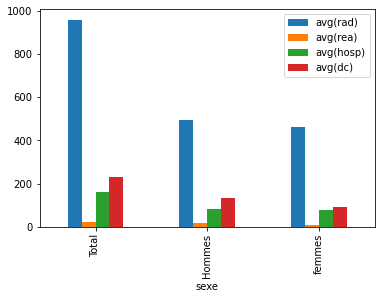

In [50]:
#datvis homme/femme
df = u.toPandas()
df.plot.bar(x = "sexe")

## 3) Quelle est la répartition des décés par rapport à la tranche d'âge ?

In [53]:
par_age = age_.groupby('group').agg(F.mean('dc')).sort('group').where(age_.group != 0)
par_age.show()

+-----+-------------------+
|group|            avg(dc)|
+-----+-------------------+
|    9| 0.1574973031283711|
|   19|0.20891765551959726|
|   29|  1.338187702265372|
|   39|  5.391945343401654|
|   49| 14.952714850773104|
|   59|  53.83243437612369|
|   69|  145.1544408486156|
|   79|    285.06436533621|
|   89|  487.0088097806544|
|   90| 279.91693635382956|
+-----+-------------------+



Dans ce jeu de données, la tranche d'âge 0 corresponds aux totals des cas, le 9 corresponds à la tranche d'âge "0 à 9 ans", le 19 corresponds à la tranche d'âge "10 à 19 ans" et ainsi de suite jusqu'à 90 qui corresponds à "90 ans et plus".

En conclusion, on peut dire que les tranches d'âge les plus touchées sont les tranches d'âge "70 à 79 ans" et "80 à 89 ans". 

<AxesSubplot:xlabel='group'>

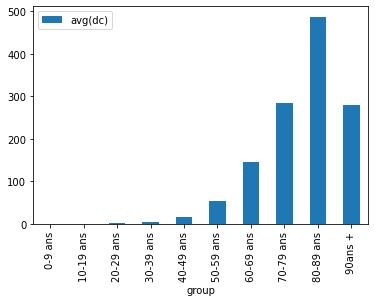

In [56]:
@udf(returnType = StringType())
def get_group(group):
    format_age = {0: "Total", 9: "0-9 ans",19: "10-19 ans",29: "20-29 ans",39: "30-39 ans",49: "40-49 ans",59: "50-59 ans",69: "60-69 ans",79: "70-79 ans",89: "80-89 ans",90: "90ans +"}
    return format_age[group]
  
    
v = par_age.withColumn("group", get_group(par_age.group))    
df_age = v.toPandas()
df_age.plot.bar(x = "group")

##  4) Quelles sont les départements recensant le plus de cas covid ?

In [102]:
par_etab = etab_.groupby('dep').agg(F.mean('nb').alias('moy_nb')).sort("moy_nb")
par_etab.collect()

[Row(dep='976', moy_nb=0.9548387096774194),
 Row(dep='48', moy_nb=1.8419354838709678),
 Row(dep='90', moy_nb=1.9419354838709677),
 Row(dep='2B', moy_nb=1.9516129032258065),
 Row(dep='09', moy_nb=2.2225806451612904),
 Row(dep='972', moy_nb=2.458064516129032),
 Row(dep='40', moy_nb=2.5),
 Row(dep='973', moy_nb=2.7129032258064516),
 Row(dep='32', moy_nb=3.0612903225806454),
 Row(dep='23', moy_nb=3.067741935483871),
 Row(dep='86', moy_nb=3.464516129032258),
 Row(dep='24', moy_nb=3.7451612903225806),
 Row(dep='82', moy_nb=4.041935483870968),
 Row(dep='47', moy_nb=4.083870967741936),
 Row(dep='16', moy_nb=4.125806451612903),
 Row(dep='19', moy_nb=4.2064516129032254),
 Row(dep='55', moy_nb=4.712903225806452),
 Row(dep='03', moy_nb=4.790322580645161),
 Row(dep='46', moy_nb=4.832258064516129),
 Row(dep='974', moy_nb=5.232258064516129),
 Row(dep='12', moy_nb=5.2709677419354835),
 Row(dep='2A', moy_nb=5.280645161290322),
 Row(dep='15', moy_nb=5.2935483870967746),
 Row(dep='70', moy_nb=5.858064516

<AxesSubplot:xlabel='dep'>

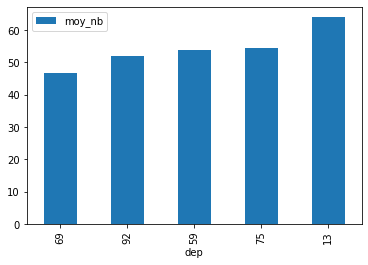

In [103]:
df_etab = par_etab.where(par_etab.moy_nb >= 40).toPandas()
df_etab.plot.bar(x='dep')

Département 13 = marseille, le plus touché


## 5) Quel mois de l'année 2020 à été touché le plus par l'épidemie ?

In [104]:
@udf(returnType = StringType())
def get_year(columdate):
    return columdate[0:4]

@udf(returnType = StringType())
def get_month_year(columdate):
    return columdate[0:7]

# cas covid en France menant à : hosp, réanimation, retour à domicile et décés, par année et par mois 
a = new_.withColumn('annee', get_year(new_.jour))
b = new_.withColumn('mois', get_month_year(new_.jour))
par_annee = a.groupby('annee').agg(F.sum('incid_dc'), F.sum('incid_rad'), F.sum('incid_rea'), F.sum('incid_hosp'))
par_annee.show()
par_mois = b.groupby('mois').agg(F.sum('incid_dc'), F.sum('incid_rad'), F.sum('incid_rea'), F.sum('incid_hosp'))
par_mois.show()

+-----+-------------+--------------+--------------+---------------+
|annee|sum(incid_dc)|sum(incid_rad)|sum(incid_rea)|sum(incid_hosp)|
+-----+-------------+--------------+--------------+---------------+
| 2020|        45531|        201224|         43488|         277861|
| 2021|         5208|         19418|          4027|          26317|
+-----+-------------+--------------+--------------+---------------+

+-------+-------------+--------------+--------------+---------------+
|   mois|sum(incid_dc)|sum(incid_rad)|sum(incid_rea)|sum(incid_hosp)|
+-------+-------------+--------------+--------------+---------------+
|2020-06|          914|          8306|           436|           3663|
|2020-12|         8594|         32684|          5334|          38214|
|2020-05|         3371|         20244|          1668|          12888|
|2020-11|        11302|         45893|          9754|          63519|
|2020-07|          420|          5702|           387|           3027|
|2020-03|         3398|        

<AxesSubplot:xlabel='mois'>

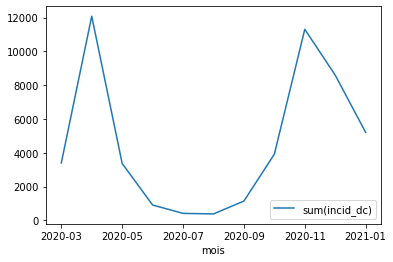

In [87]:
df_month = par_mois.select('mois', 'sum(incid_dc)').sort('mois').toPandas()
df_month.plot(x = 'mois')

En conclusion, le mois le plus touché par l'épidemie du covid 19 est le mois d'Avril de l'année 2020 suivi par le mois de Novembre 2020. Soit les deux mois où la France était en confinement.

## 6) Quelle est l'évolution des nouveaux cas de covid en janvier 2021 ?

In [80]:
par_jour_2021 = a.where(a.annee == 2021).groupby('jour').agg(F.mean('incid_dc').alias('moy_janvier')).sort('jour')
par_jour_dec_2020 = b.where(b.mois == "2020-12").groupby('jour').agg(F.mean('incid_dc').alias('moy_decembre')).sort('jour')
par_jour_2021.show()
par_jour_dec_2020.show()

+----------+------------------+
|      jour|       moy_janvier|
+----------+------------------+
|2021-01-01| 1.316831683168317|
|2021-01-02|1.5544554455445545|
|2021-01-03|1.1485148514851484|
|2021-01-04| 3.762376237623762|
|2021-01-05|3.4257425742574257|
|2021-01-06| 2.881188118811881|
|2021-01-07| 2.742574257425743|
|2021-01-08| 2.782178217821782|
|2021-01-09| 1.693069306930693|
|2021-01-10| 1.495049504950495|
|2021-01-11|3.0693069306930694|
|2021-01-12|3.5841584158415842|
|2021-01-13| 2.297029702970297|
|2021-01-14| 2.801980198019802|
|2021-01-15|2.8514851485148514|
|2021-01-16|1.9405940594059405|
|2021-01-17| 1.396039603960396|
|2021-01-18|               4.0|
|2021-01-19|3.6930693069306932|
|2021-01-20| 3.128712871287129|
+----------+------------------+

+----------+------------------+
|      jour|      moy_decembre|
+----------+------------------+
|2020-12-01| 3.613861386138614|
|2020-12-02| 3.089108910891089|
|2020-12-03| 3.227722772277228|
|2020-12-04|2.8118811881188117|
|2020-1

<AxesSubplot:xlabel='jour'>

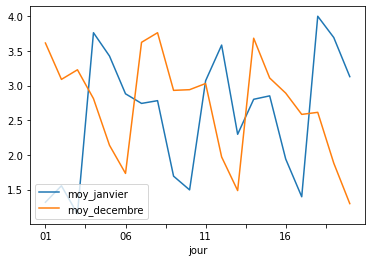

In [83]:
@udf(returnType = StringType())
def format_jour(jour):
    return jour[8:10]

a = par_jour_2021.withColumn('jour', format_jour(par_jour_2021.jour))
b = par_jour_dec_2020.withColumn('jour', format_jour(par_jour_dec_2020.jour))
c = a.join(b, on="jour").sort('jour')
df_jour = c.toPandas()
df_jour.plot(x = 'jour')

## 7) Lancer un job spark-submit

In [38]:
!ls

 data				 requirements2.txt
 Data_covid.ipynb		 requirements.txt
 DATA_COVID_présentation.ipynb	 script.py
 model				'TP_charger_de_la_donnee(revu).ipynb'


In [41]:
!spark-submit script.py

21/01/22 13:59:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
]0;IPython: jovyan/workUsing Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
21/01/22 13:59:26 INFO SparkContext: Running Spark version 3.0.1
21/01/22 13:59:26 INFO ResourceUtils: ==============================================================
21/01/22 13:59:26 INFO ResourceUtils: Resources for spark.driver:

21/01/22 13:59:26 INFO ResourceUtils: ==============================================================
21/01/22 13:59:26 INFO SparkContext: Submitted application: script.py
21/01/22 13:59:27 INFO SecurityManager: Changing view acls to: jovyan
21/01/22 13:59:27 INFO SecurityManager: Changing modify acls to: jovyan
21/01/22 13:59:27 INFO SecurityManager: Changing view acls groups to: 
21/01/22 13:59:27 INFO SecurityManager: Changing modify acls groups to: 
21/01/22 13:59:27 INFO SecurityManager: SecurityManager: authe

In [43]:
!cat data/output/part-00000

['2020-03', 3398, 9137, 6832, 33844]
['2020-04', 12075, 42444, 9051, 61508]
['2020-05', 3371, 20244, 1668, 12888]
['2020-06', 914, 8306, 436, 3663]
['2020-07', 420, 5702, 387, 3027]
['2020-08', 388, 4748, 693, 4566]
['2020-09', 1149, 10619, 2492, 13979]
['2020-10', 3920, 21447, 6841, 42653]
['2020-11', 11302, 45893, 9754, 63519]
['2020-12', 8594, 32684, 5334, 38214]
['2021-01', 5208, 19418, 4027, 26317]


##  Autres Données 

In [9]:
avg_dep = new_.groupby('dep').agg(F.mean('incid_dc'), F.mean('incid_rea'), F.mean('incid_rad'), F.mean('incid_hosp')).sort('dep')
avg_dep.show()

+----+-------------------+-------------------+------------------+------------------+
| dep|      avg(incid_dc)|     avg(incid_rea)|    avg(incid_rad)|   avg(incid_hosp)|
+----+-------------------+-------------------+------------------+------------------+
|null|0.19642857142857142|0.25811688311688313|0.9172077922077922|1.2873376623376624|
|   1| 1.4090909090909092|  0.974025974025974| 5.863636363636363|  8.11038961038961|
|   2| 1.9967532467532467|  1.103896103896104| 7.759740259740259| 10.62012987012987|
|   3| 1.2694805194805194| 0.6136363636363636| 4.185064935064935| 6.288961038961039|
|   4|0.42857142857142855|0.18181818181818182| 1.974025974025974|3.1298701298701297|
|   5| 0.5324675324675324|  0.461038961038961|2.2759740259740258|3.4935064935064934|
|   6| 2.4155844155844157| 2.6201298701298703| 10.12987012987013|15.003246753246753|
|   7| 1.1168831168831168|  0.512987012987013| 4.483766233766234| 6.237012987012987|
|   8| 0.8344155844155844|0.43506493506493504|2.2987012987012987|

In [10]:
dc_day = cases_.groupby('jour').agg(F.mean('dc')).describe('avg(dc)').show()

+-------+------------------+
|summary|           avg(dc)|
+-------+------------------+
|  count|               309|
|   mean| 151.7789419718671|
| stddev| 73.34191972297354|
|    min|1.4356435643564356|
|    max|  328.983498349835|
+-------+------------------+

